In [1]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=10, threads_per_worker=20, dashboard_address=':0')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33827 Dashboard: /user/lemonnn-8-dask-examples-rgt1kimn/proxy/37729/status,Cluster Workers: 10 Cores: 200 Memory: 54.88 GB


In [ ]:
!pip install s3fs

In [3]:
import dask.dataframe as dd
s3_df = dd.read_csv('s3://nyc-tlc/misc/taxi _zone_lookup.csv',storage_options={'anon': True})
s3_df.tail()

,LocationID,Borough,Zone,service_zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN
264,265,Unknown,NaN,NaN


In [ ]:
!pip install gcsfs
!pip install fastparquet

In [7]:
import pandas as pd
gcs_df = dd.read_parquet('gcs://anaconda-public-data/nyc-taxi/nyc.parquet/part.0.parquet', engine='fastparquet')
gcs_df.persist()

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
npartitions=1,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,datetime64[ns],int64,float64,float64,float64,int64,object,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
gcs_df=gcs_df.compute()

In [9]:
from sqlalchemy import create_engine
# username = "root"
# password = "root"
# port = 7777
# database = "taxi"

taxi = create_engine('sqlite:///taxi.db', echo=False)

In [10]:
gcs_df['tpep_pickup_datetime'] = gcs_df['tpep_pickup_datetime'].dt.hour
gcs_df['tpep_dropoff_datetime'] = gcs_df['tpep_dropoff_datetime'].dt.hour

In [11]:
import sqlite3
# Create your connection.
cnx = sqlite3.connect('taxi')

In [12]:
gcs_df.to_sql('taxi_record', con=cnx, if_exists='append')

In [13]:
df_pu = pd.read_sql_query('SELECT tpep_pickup_datetime AS time, count(*) AS PUcount \
                        FROM taxi_record \
                        GROUP BY tpep_pickup_datetime', cnx)

In [14]:
df_do = pd.read_sql_query('SELECT tpep_dropoff_datetime AS time, count(*) AS DOcount \
                        FROM taxi_record \
                        GROUP BY tpep_dropoff_datetime', cnx)

In [15]:
df_q2 = df_pu.merge(df_do, on="time")

In [16]:
df_q2.head()

,time,PUcount,DOcount
0,0,57167,51182
1,1,54658,56039
2,2,45702,47873
3,3,37813,39491
4,4,26768,29740


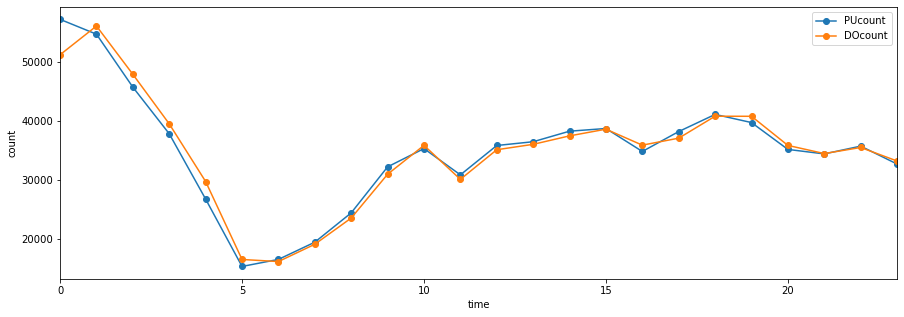

In [18]:
import matplotlib.pyplot as p
%matplotlib inline
ax = df_q2.plot(x='time', y=['PUcount', 'DOcount'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
p.show()

In [ ]:
# As we can see peak hour is from 12AM to 1 AM
# and ff-peak hour is 5 AM